# PCA exploration with MAIZSIM yield outputs
1. Cultivar-specific yield as samples & sites as features
2. Cultivar-specific yield as samples & parameters as features

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from palettable.colorbrewer.sequential import Purples_9
from palettable.colorbrewer.sequential import YlGn_9
from palettable.colorbrewer.diverging import PuOr_8

from ideotype.data_process import read_data, agg_sims
from ideotype.analysis import run_pca

In [2]:
# read in data
yamlfile = '/home/disk/eos8/ach315/ideotype/ideotype/data/files/filepaths.yml'
df_sims, df_sites, df_wea, df_params, df_all, df_matured = read_data(yamlfile)

## 1. PCA: cultivars as samples (rows) & sites as features (columns)
Outputs capture underlying patterns within sites that contribute to yield variation between sites.

variance explaiend:  [0.90905086 0.07160725 0.00724609 0.00286045 0.00241659]


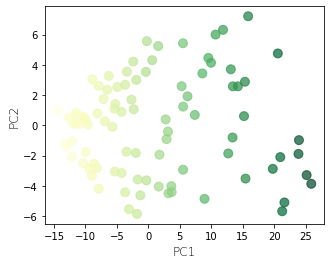

In [4]:
# pca
mx_mean = agg_sims(df_all, ['cvar', 'site'], 'mean')
pca, df_pca = run_pca(mx_mean, 5)

# visualizing pca output
fig = plt.figure(figsize = (5,4))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 12, fontweight='light')
ax.set_ylabel('PC2', fontsize = 12, fontweight='light')
ax.scatter(df_pca.loc[:,'PC1'], df_pca.loc[:, 'PC2'], 
           c=pd.DataFrame(mx_mean).mean(axis=1),  # mean yield across sites for each cultivar
           s=80, alpha=0.7, cmap=YlGn_9.mpl_colormap)
print('variance explaiend: ', pca.explained_variance_ratio_)

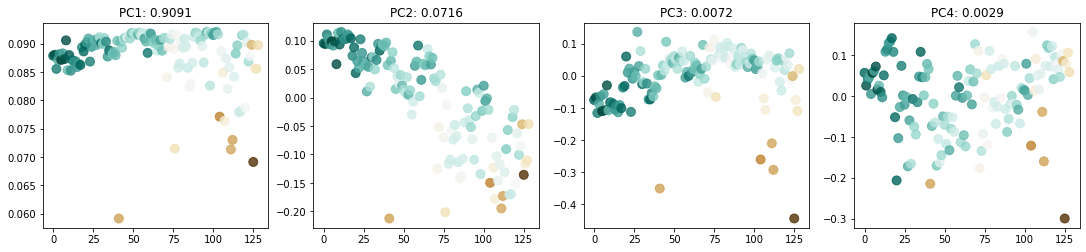

In [6]:
# component values with yield mean at each site
comps = [0,1,2,3]

fig, axs = plt.subplots(1, 4, figsize=(16,3))
for comp, ax in zip(comps, axs.flatten()):
    ax.scatter(np.arange(129), pca.components_[comp],
               c=pd.DataFrame(mx_mean).mean(axis=0),
               cmap='BrBG', alpha=0.8, s=80)
    ax.set_title(f'PC{comp+1}: {round(pca.explained_variance_ratio_[comp],4)}')

fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=0.95, wspace=0.2, hspace=0)

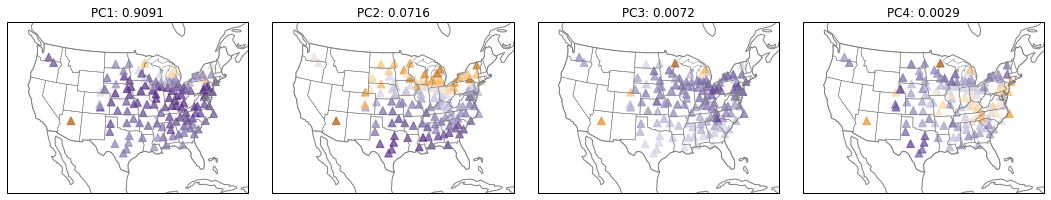

In [8]:
# projecting PC1 component values back onto map
comps = [0,1,2,3]
axnums = [1,2,3,4]

fig = plt.figure(figsize=(16,4))
for axnum, comp in zip(axnums, comps):
    ax = fig.add_subplot(1,4,axnum, projection=ccrs.AlbersEqualArea(
                         central_latitude=39.5, central_longitude=-98.35))
    ax.set_extent([-123, -72, 19, 53])
    ax.scatter(df_sites.lon[:-1], df_sites.lat[:-1],  # excluding last site that has no sim data
               transform=ccrs.PlateCarree(), s=60, marker='^',
               c=pca.components_[comp], alpha=0.7, 
               cmap=PuOr_8.mpl_colormap)
#               cmap='RdPu')  # visualize PC1 components
    ax.set_title(f'PC{comp+1}: {round(pca.explained_variance_ratio_[comp],4)}')
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)

fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=0.95, wspace=0.1, hspace=0.45)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/pcamaps_onyield.pnb', format='png', dpi=800)

### consider all data

In [304]:
features = ['temp', 'rh', 'precip', 'solrad',
            'juv_leaves', 'stayGreen', 'rmax_ltir', 'phyllo', 'LM_min',
            'Vcmax', 'Vpmax', 'g1', 'ref_potential']
target = 'dm_ear'

df_all[features].head()

,temp,rh,precip,solrad,juv_leaves,stayGreen,rmax_ltir,phyllo,LM_min,Vcmax,Vpmax,g1,ref_potential
0,22.527191,74.713304,881.8,234.060642,23,4.44,1.24,3.31,98.77,77.29,92.57,9.86,-3.38
1,22.527191,74.713304,881.8,234.060642,16,7.13,0.55,3.98,89.85,67.10,87.81,1.37,-2.83
2,22.527191,74.713304,881.8,234.060642,21,6.51,1.00,3.04,81.24,66.65,81.56,3.88,-2.63
3,22.527191,74.713304,881.8,234.060642,24,4.67,0.68,3.24,97.70,69.56,69.67,4.86,-3.63
4,22.527191,74.713304,881.8,234.060642,20,4.32,0.82,3.13,115.08,64.44,101.27,6.31,-3.40


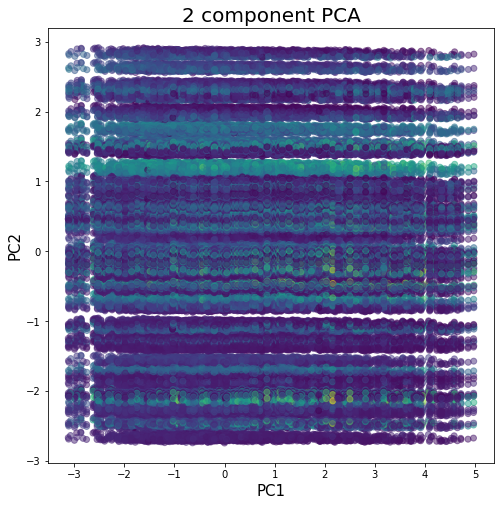

In [111]:
x = df_all.loc[:, features]
x = StandardScaler().fit_transform(x)
y = df_all.loc[:, target].values

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['PC1', 'PC2'])
finalDF = pd.concat([principalDf, df_all.loc[:,target]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

ax.scatter(finalDF.loc[:,'PC1'], finalDF.loc[:, 'PC2'],
           c = finalDF.dm_ear, alpha=0.5)

In [88]:
pca.explained_variance_ratio_

array([0.14296356, 0.1348279 ])

### consider cultivar + site

In [310]:
features = ['temp', 'rh', 'precip', 'solrad',
            'juv_leaves', 'stayGreen', 'rmax_ltir', 'phyllo', 'LM_min',
            'Vcmax', 'Vpmax', 'g1', 'ref_potential', 'dm_ear']
target = 'dm_ear'

df_pca = df_all.groupby(['cvar','site']).mean().reset_index()
df_pca[features].head()

,temp,rh,precip,solrad,juv_leaves,stayGreen,rmax_ltir,phyllo,LM_min,Vcmax,Vpmax,g1,ref_potential,dm_ear
0,23.448432,73.102946,741.059091,229.759914,23.0,4.44,1.24,3.31,98.77,77.29,92.57,9.86,-3.38,66.596818
1,23.145051,75.116173,925.895500,229.412050,23.0,4.44,1.24,3.31,98.77,77.29,92.57,9.86,-3.38,70.157200
2,23.636775,75.251082,898.192982,231.491352,23.0,4.44,1.24,3.31,98.77,77.29,92.57,9.86,-3.38,70.965263
3,22.890561,71.303964,526.993939,230.217785,23.0,4.44,1.24,3.31,98.77,77.29,92.57,9.86,-3.38,60.676818
4,22.125387,72.198567,533.709259,229.844983,23.0,4.44,1.24,3.31,98.77,77.29,92.57,9.86,-3.38,57.915000


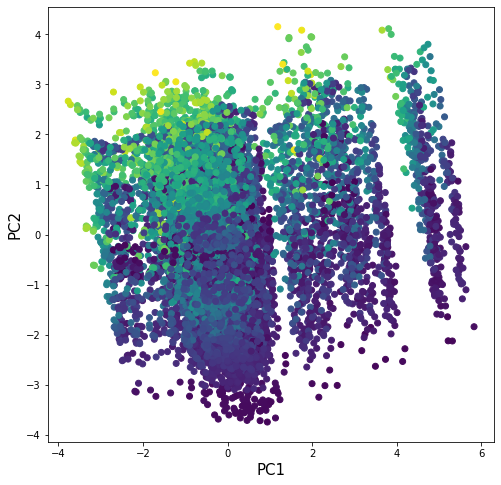

In [311]:
x = df_pca.loc[:, features]
x = StandardScaler().fit_transform(x)
y = df_pca.loc[:, target].values

pca = PCA(n_components=10)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5',
                                      '6','7','8','9','10'])
finalDF = pd.concat([principalDf, df_pca.loc[:,target]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)

ax.scatter(finalDF.loc[:,'PC1'], finalDF.loc[:, 'PC2'],
           c = finalDF.dm_ear)

In [312]:
pca.explained_variance_ratio_

array([0.15097189, 0.13222293, 0.11936484, 0.10950949, 0.09304233,
       0.08090325, 0.06353001, 0.06168197, 0.05741092, 0.05258318])

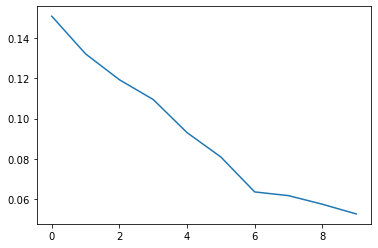

In [154]:
plt.plot(pca.explained_variance_ratio_)

In [319]:
df_pcaresults = pd.DataFrame(
    {'features': features,
     'PC1': pca.components_[0],
     'PC2': pca.components_[1]})
df_pcaresults.sort_values(by='PC1', ascending=False)

,features,PC1,PC2
3,solrad,0.254679,0.245963
10,Vpmax,0.088316,-0.534329
4,juv_leaves,0.036501,-0.317780
9,Vcmax,0.029101,-0.136697
11,g1,0.001951,-0.176395
7,phyllo,-0.015109,0.081548
6,rmax_ltir,-0.031854,-0.115166
5,stayGreen,-0.032552,0.138210
8,LM_min,-0.046079,0.120447
12,ref_potential,-0.062144,0.438459


### only consider parameter perturbation

In [160]:
features = ['juv_leaves', 'stayGreen', 'rmax_ltir', 'phyllo', 'LM_min',
            'Vcmax', 'Vpmax', 'g1', 'ref_potential', 'dm_ear']
target = 'dm_ear'

In [161]:
df_pca = df_all.groupby(['cvar']).mean().reset_index()
df_pca.head()

,cvar,year,jday,time,leaves,mature_lvs,drop_lvs,LA,LA_dead,LAI,...,precip,solrad,vpd,class_y,tzone_y,lat_y,lon_y,years_y,area_y,perct_irri_y
0,0,1980.181709,29517.791534,12.172923,23.103187,23.101038,18.195687,331.044748,6145.241621,0.264808,...,536.567101,220.066130,0.709642,1.029952,-5.611422,38.788779,-88.445692,22.040335,16748.916846,6.579657
1,1,1980.088953,29516.650393,12.880844,16.706678,16.705834,13.762102,288.201196,2900.385999,0.230712,...,540.124585,220.418624,0.713517,1.031030,-5.590401,38.587334,-88.169071,22.011585,16358.473921,6.463964
2,2,1980.164577,29529.398302,12.503841,21.091156,21.090578,17.685402,230.336555,3759.799216,0.185419,...,538.873725,220.129691,0.710236,1.030328,-5.599677,38.709954,-88.294296,22.026688,16763.491728,6.442312
3,3,1980.128299,29518.276898,12.710922,24.223435,24.219651,19.543240,466.853967,6722.545185,0.373447,...,538.918279,220.231846,0.711171,1.030451,-5.598863,38.687888,-88.285179,22.020706,16656.018074,6.464182
4,4,1980.143841,29522.884522,12.571313,20.095016,20.092382,16.130065,388.388298,6207.974498,0.310656,...,538.660827,220.182158,0.710686,1.030389,-5.599271,38.699001,-88.293961,22.021475,16722.563506,6.469305


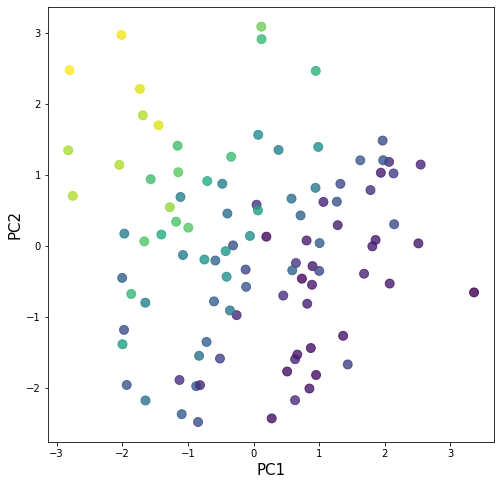

In [162]:
x = df_pca.loc[:, features]
x = StandardScaler().fit_transform(x)
y = df_pca.loc[:, target].values

pca = PCA(n_components=5)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
finalDF = pd.concat([principalDf, df_pca.loc[:,target]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)

ax.scatter(finalDF.loc[:,'PC1'], finalDF.loc[:, 'PC2'],
           c = finalDF.dm_ear, s=80, alpha=0.8)

In [140]:
pca.explained_variance_ratio_

array([0.186275  , 0.16442296, 0.13056456, 0.11358224, 0.08895631])

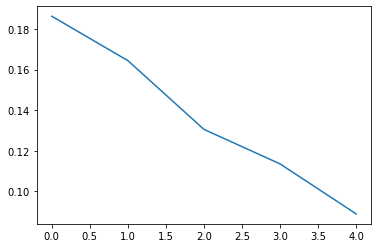

In [141]:
plt.plot(pca.explained_variance_ratio_)

In [142]:
features

['juv_leaves',
 'stayGreen',
 'rmax_ltir',
 'phyllo',
 'LM_min',
 'Vcmax',
 'Vpmax',
 'g1',
 'ref_potential',
 'dm_ear']

In [143]:
pca.components_[0]

array([ 0.32240334, -0.15663453,  0.07727223, -0.08913581, -0.15393197,
        0.15330794,  0.56404023,  0.16068079, -0.45505764, -0.5092838 ])

In [144]:
pca.components_[1]

array([ 0.23168985,  0.133916  ,  0.53829027,  0.02090634,  0.39235514,
       -0.15968644,  0.10114564,  0.44613812, -0.20699292,  0.45457099])

### Consider cultivar impace for single site

In [116]:
df_pca = df_all[df_all.site == '722070']

features = ['temp', 'rh', 'precip', 'solrad',
            'juv_leaves', 'stayGreen', 'rmax_ltir', 'phyllo', 'LM_min',
            'Vcmax', 'Vpmax', 'g1', 'ref_potential']
target = 'dm_ear'

df_pca[features].head()

,temp,rh,precip,solrad,juv_leaves,stayGreen,rmax_ltir,phyllo,LM_min,Vcmax,Vpmax,g1,ref_potential
0,22.527191,74.713304,881.8,234.060642,23,4.44,1.24,3.31,98.77,77.29,92.57,9.86,-3.38
1,22.527191,74.713304,881.8,234.060642,16,7.13,0.55,3.98,89.85,67.10,87.81,1.37,-2.83
2,22.527191,74.713304,881.8,234.060642,21,6.51,1.00,3.04,81.24,66.65,81.56,3.88,-2.63
3,22.527191,74.713304,881.8,234.060642,24,4.67,0.68,3.24,97.70,69.56,69.67,4.86,-3.63
4,22.527191,74.713304,881.8,234.060642,20,4.32,0.82,3.13,115.08,64.44,101.27,6.31,-3.40


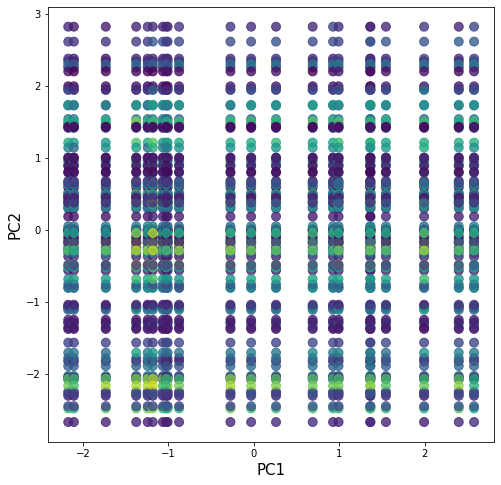

In [117]:
x = df_pca.loc[:, features]
x = StandardScaler().fit_transform(x)
y = df_pca.loc[:, target].values

pca = PCA(n_components=5)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
finalDF = pd.concat([principalDf, df_pca.loc[:,target]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)

ax.scatter(finalDF.loc[:,'PC1'], finalDF.loc[:, 'PC2'],
           c = finalDF.dm_ear, s=80, alpha=0.8)

### consider single site & year

In [112]:
df_pca = df_all[(df_all.site == '722070') & (df_all.year == 1961)]

features = ['juv_leaves', 'stayGreen', 'rmax_ltir', 'phyllo', 'LM_min',
            'Vcmax', 'Vpmax', 'g1', 'ref_potential']
target = 'dm_ear'

df_pca[features].head()

,juv_leaves,stayGreen,rmax_ltir,phyllo,LM_min,Vcmax,Vpmax,g1,ref_potential
0,23,4.44,1.24,3.31,98.77,77.29,92.57,9.86,-3.38
1,16,7.13,0.55,3.98,89.85,67.10,87.81,1.37,-2.83
2,21,6.51,1.00,3.04,81.24,66.65,81.56,3.88,-2.63
3,24,4.67,0.68,3.24,97.70,69.56,69.67,4.86,-3.63
4,20,4.32,0.82,3.13,115.08,64.44,101.27,6.31,-3.40


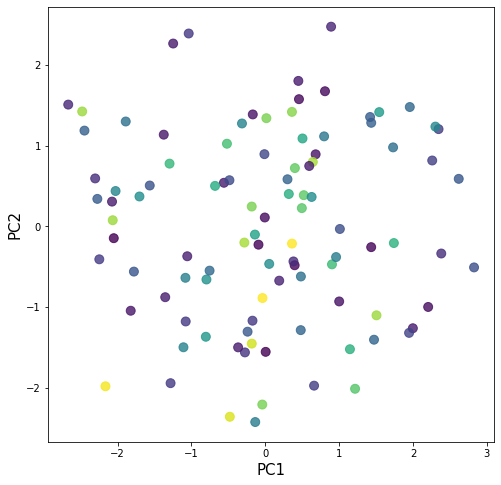

In [113]:
x = df_pca.loc[:, features]
x = StandardScaler().fit_transform(x)
y = df_pca.loc[:, target].values

pca = PCA(n_components=5)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
finalDF = pd.concat([principalDf, df_pca.loc[:,target]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)

ax.scatter(finalDF.loc[:,'PC1'], finalDF.loc[:, 'PC2'],
           c = finalDF.dm_ear, s=80, alpha=0.8)

In [108]:
pca.explained_variance_ratio_

array([0.19464533, 0.14838891, 0.13355437, 0.10865142, 0.09774583])